In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import seaborn as sns
import random
import sys

In [57]:
def norm(vec):
    return vec/255

def get_feature_vector(filename):
    """
        Reads an image of dimensions (WXHXC) and returns a numpy array of size (N X C)
        
        Here N = WXH represents the no:of features and C is the no:of color
        channels (3 for RGB and 1 for Grayscale)
        
        Note: It also normalizes the image
    """
    img = mpimg.imread(filename)
    assert(len(img.shape) == 3)
    w = img.shape[0]
    h = img.shape[1]
    c = img.shape[2]
    feature_vec = img.reshape(w * h, c)
    feature_vec = norm(feature_vec)
    return feature_vec, w, h, c

In [64]:
def plot_images(old_arr, new_arr, w, h, c, size):
    """
        Given 2 numpy arrays of size N X C, this function converts
        it into another array of size W X H X C where (N = W X H) and
        plots the images side-by-side
    """
    old_img = old_arr.reshape(w, h, c)
    new_img = new_arr.reshape(w, h, c)
    
    if size != None:
        fig = plt.figure(figsize=size)
    else:
        fig = plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.imshow(old_img)
    plt.title("Before compression")
    
    plt.subplot(1, 2, 2)
    plt.imshow(new_img)
    plt.title("After compression")

In [4]:
def random_initialize(vec, K):
    """
        Takes a vector of size M X N and the no:of clusters required
        Returns a vector of size K X N by randomly selecting K rows
        from M rows
    """
    M = vec.shape[0]
    indices = np.random.choice(M, K)
    return vec[indices]

def cluster_assign(vec, cluster_centroids):
    """
        Takes 2 vectors as input:
            vec: of size M X N
            cluster_centroids: of size K X N
            
        Returns a vector of size (M,) whose elements range from [0, K-1], i.e.
        they belong to one of the K cluster centroids. It is calculated by taking
        the L2 norm of each row of vec with all of the K rows of cluster_centroids,
        and then finding the minimum one
    """
    M = vec.shape[0]
    K = cluster_centroids.shape[0]
    c = []
    for i in range(M):
        row = vec[i,:]
        min_val = sys.maxsize
        min_index = None
        for j in range(K):
            centroid = cluster_centroids[j,:]
            norm_val = np.square(np.linalg.norm(row - centroid))
            if norm_val < min_val:
                min_val = norm_val
                min_index = j
        c.append(min_index)
    c = np.array(c)
    return c

def compute_distortion_cost(cluster_elems, cluster_centroid):
    """
        Given cluster_elems vector of size: C X N, where C is some number,
        and cluster_centroid of size: (N,), this function computes the distortion
        cost function, which is:
        
            ||cluster_elems - cluster_centroid||^2
    """
    N = cluster_elems.shape[1]
    cluster_centroid = cluster_centroid.reshape(1, N)
    return np.square(np.linalg.norm(cluster_elems - cluster_centroid))

def move_centroid(vec, cluster_centroids, c):
    """
        Given 3 vectors:
            vec: of size M X N
            cluster_centroids: of size K X N
            c of size: M X 1
        
        For each cluster centroid 'lambda', this function computes the average
        of all elements in vec which belong to 'lambda' and returns a vector of
        size: K X N
        
        It also returns the total cost of the current system. Which is defined as
        the sum of averages of all elements belonging to a cluster
    """
    M = vec.shape[0]
    K = cluster_centroids.shape[0]
    N = cluster_centroids.shape[1]
    new_cluster_centroids = []
    total_cost = 0
    
    for i in range(K):
        cluster_elems = vec[(c == i).nonzero()]
        
        if cluster_elems.shape[0] == 0:
            print("[WARN] Cluster no: " + str(i) + " is not assigned to any example")
            # Don't change the centroid of this cluster, simply add it to new_cluster_centroids list
            new_cluster_centroids = new_cluster_centroids + (np.squeeze(cluster_centroids[i,:]).tolist())
            
            """
                This case occurs when in cluster_assignment step, the cluster with
                index 'i' (i.e. ith cluster among the K clusters) is not assigned to
                any of the data points. This is very much possible if you imagine
                properly.
                
                In this situation, there is no point in calculating the distortion
                cost, nor is there is any point in moving this cluster centroid (since
                no points are assigned to this cluster). Therefore we simply continue.
                
                The consequence of this design is that the total distortion cost
                will be high, since we are unable to initialize the K-means properly.
                This is the reason why it is recommended to run the entire K-means
                multiple times.
                
                Note that this situation will can arise two dissimilar situations:
                (i) When the actual no:of clusters in the dataset are 'alpha' and
                you decide to set K to value > 'alpha' (most common scenario)
                (ii) When K < 'alpha', but initialization was wrong. Typically this
                won't occur frequently, but if were to occur it can be overcome to
                a certain extent by repeated initialization
            """
            continue
        
        cost = compute_distortion_cost(cluster_elems, cluster_centroids[i,:])
        total_cost = total_cost + cost
        
        new_cluster_pos = np.mean(cluster_elems, axis=0, keepdims=True)
        assert new_cluster_pos.shape == (1, N) # Sanity check
        new_cluster_centroids = new_cluster_centroids + (np.squeeze(new_cluster_pos).tolist())
    
    total_cost = total_cost / M

    assert len(new_cluster_centroids) == (K * N) # Sanity check
    new_cluster_centroids = np.array(new_cluster_centroids).reshape(K, N)
    return new_cluster_centroids, total_cost

def should_terminate(cluster_centroids, new_cluster_centroids, epsilon):
    """
        Given 2 (cluster_centroid) arrays of size K X N, this function
        computes their L2 norm and returns true if it is less than epsilon
    """
    K = cluster_centroids.shape[0]
    result_arr = []
    for i in range(K):
        result = np.square(np.linalg.norm(cluster_centroids[i,:] - new_cluster_centroids[i,:]))
        result_arr.append(result)
    diff_arr = [result for result in result_arr if result > epsilon]
    return len(diff_arr) == 0

def plot_cluster_centroid(vec, cluster_centroids, title_suffix):
    """
        Given 2 arrays of size:
            vec: of size M X N
            cluster_cntroids: of size K X N
            
        This function plots the vec and cluster_centroids on the graph with
        different colors
    """
    
    N = vec.shape[1]
    assert N == 2
    x_vals = vec[:,0]
    y_vals = vec[:,1]
    clust_x_vals = cluster_centroids[:,0]
    clust_y_vals = cluster_centroids[:,1]
    fig = plt.figure()
    if title_suffix != None:
        plt.title("K-means (" + title_suffix + ")")
    else:
        plt.title("K-means")
    plt.scatter(x_vals, y_vals, color='g', marker='o')
    plt.scatter(clust_x_vals, clust_y_vals, color='r', marker='v', s=128)

def categorize(vec, c):
    """
        Given 2 arrays of size:
            vec: of size M X N
            c: of size of size (M,)
            
        This function labels all the datapoints in 'vec'
        based on their clusters in 'c'
    """
    classes = np.unique(c)
    categories = []
    for class_label in classes:
        datapoints = vec[(c == class_label).nonzero()]
        categories.append(datapoints.tolist())
    return categories

def plot_clusters(vec, c):
    """
        Given 2 arrays of size:
            vec: of size M X N
            c: of size of size (M,)
            
        This function plots the clusters
    """
    
    N = vec.shape[1]
    assert N == 2
    
    categories = categorize(vec, c)

    fig = plt.figure()
    plt.title("Clusters formed by K-means")
    colors = cm.rainbow(np.linspace(0, 1, len(categories)))
    for category, c in zip(categories, colors):
        category = np.array(category)
        x = category[:,0]
        y = category[:,1]
        plt.scatter(x, y, color=c)
    
def plot_distortion_cost(cost_arr):
    fig = plt.figure()
    plt.plot(cost_arr)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.title("K-means progress (distortion cost function)")
    

def k_means(vec, K=2, epsilon=10e-7, max_iters=1000, factor=10,
            plot_main_figs=False, plot_progress=False, plot_cost=False,
            print_desc=False):
    """
        Takes a vector of size M X N and the no:of clusters (K) required
        Returns a vector of size K X N
        
        Note: epsilon is the difference between new cluster centroids and the old
        ones. The inner loop of k-means will terminate when the difference falls
        below epsilon. 'max_iters' on the other hand will ensure that the inner loop
        will run no more times than 'max_iters'
    """
    if(print_desc):
        print("=" * 40)
        print("Starting K-means")
    
    cluster_centroids = random_initialize(vec, K)
    if plot_main_figs:
        plot_cluster_centroid(vec, cluster_centroids, "initial")
    
    cost_arr = []
    converged = False
    c = None
    
    for i in range(max_iters):
        if (print_desc and i % (max_iters/factor) == 0):
            print("Running iteration: " + str(i) + " ...")
        
        c = cluster_assign(vec, cluster_centroids)
        
        new_cluster_centroids, cost = move_centroid(vec, cluster_centroids, c)
        cost_arr.append(cost)
        
        yes = should_terminate(cluster_centroids, new_cluster_centroids, epsilon)
        
        cluster_centroids = new_cluster_centroids
        if plot_progress and (i % (max_iters/factor) == 0):
            plot_cluster_centroid(vec, cluster_centroids, "itr: " + str(i))
        
        if yes:
            if print_desc:
                print("Converged at iteration: " + str(i))
            converged = True
            break
            
    if not converged:
        print("[WARN] Max iterations reached, K-means did not converge yet. Forcefully terminating!")

    if plot_main_figs:
        plot_cluster_centroid(vec, cluster_centroids, "final")    
    
    if(print_desc):
        print("Min cost: " + str(cost_arr[-1]))
        print("=" * 40)
    
    if plot_cost:
        plot_distortion_cost(cost_arr)
        
    return cluster_centroids, cost_arr, c

In [65]:
filename = 'ironman.jpg'
feature_vec, w, h, c = get_feature_vector(filename)

print("Feature vector shape: " + str(feature_vec.shape))

reduced_feature_vec, cost_arr, cluster_labels = k_means(feature_vec, K=16,
                                                            epsilon=10e-7, max_iters=5000,
                                                            factor=500, plot_main_figs=False,
                                                            plot_progress=False, plot_cost=False,
                                                            print_desc=True)

Feature vector shape: (448900, 3)
Starting K-means
Running iteration: 0 ...
Running iteration: 10 ...
Running iteration: 20 ...
Running iteration: 30 ...
Running iteration: 40 ...
Running iteration: 50 ...
Running iteration: 60 ...
Running iteration: 70 ...
Running iteration: 80 ...
Running iteration: 90 ...
Running iteration: 100 ...
Running iteration: 110 ...
Converged at iteration: 112
Min cost: 0.005949931818014106


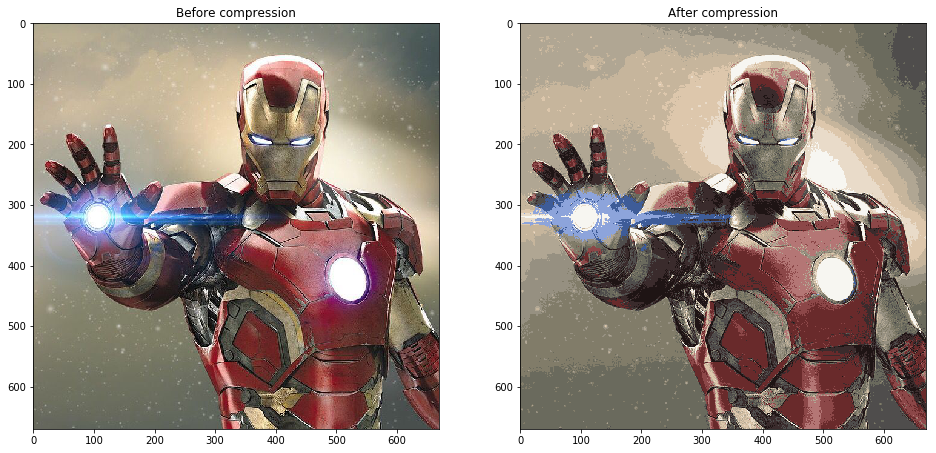

In [68]:
comp_img_vec = reduced_feature_vec[cluster_labels]
plot_images(feature_vec, comp_img_vec, w, h, c, (16, 8))

In [69]:
filename = 'ironman.jpg'
feature_vec, w, h, c = get_feature_vector(filename)

print("Feature vector shape: " + str(feature_vec.shape))

reduced_feature_vec, cost_arr, cluster_labels = k_means(feature_vec, K=4,
                                                            epsilon=10e-7, max_iters=5000,
                                                            factor=500, plot_main_figs=False,
                                                            plot_progress=False, plot_cost=False,
                                                            print_desc=True)

Feature vector shape: (448900, 3)
Starting K-means
Running iteration: 0 ...
Running iteration: 10 ...
Converged at iteration: 14
Min cost: 0.021518046623806585


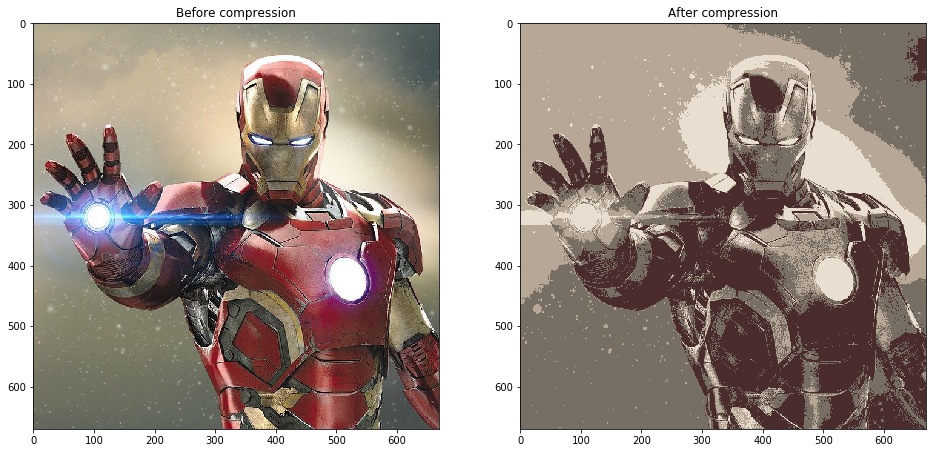

In [70]:
comp_img_vec = reduced_feature_vec[cluster_labels]
plot_images(feature_vec, comp_img_vec, w, h, c, (16, 8))